## Installing the required library for app review scraping

Before starting, we install the `google-play-scraper` library, which allows us to programmatically retrieve user reviews from the Google Play Store. This will be our primary source of real-world user feedback for this project.


In [1]:
pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00


## Scraping Duolingo user reviews and saving to CSV

In this section, we collect 100 of the latest English-language user reviews for Duolingo from the US market.  
Using the `google-play-scraper` library, we extract the review text, score, and timestamp.  
The collected data is then organized into a structured DataFrame and saved as a CSV file for further analysis.


In [2]:
from google_play_scraper import reviews, Sort

# Scraping Duolingo comments
result, _ = reviews(
    'com.duolingo',  # Duolingo app ID
    lang='en',       # English comments
    country='us',    # USA users
    sort=Sort.NEWEST,  # Newest comments
    count=100,       # Comment amount
)

# Getting comments as text
import pandas as pd

reviews_df = pd.DataFrame([{
    'content': r['content'],
    'score': r['score'],
    'at': r['at']
} for r in result])

# Saving as .csv
reviews_df.to_csv('duolingo_reviews.csv', index=False)


## Step 1: Load and preview the user reviews dataset

In this step, we import the previously collected Duolingo user reviews from the CSV file.  
The goal is to confirm that the data has been successfully collected and to get an initial sense of its structure.


In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('duolingo_reviews.csv')

# Preview the first few rows
df.head()


,content,score,at
0,remove the slider from the math lessons it's s...,3,2025-04-25 21:09:31
1,I have so many Spanish friends and now I can s...,5,2025-04-25 21:06:58
2,Great... Just. Uhh great yes it is very *click...,5,2025-04-25 21:06:15
3,best app ever 👍 👍 😁,5,2025-04-25 21:03:09
4,immersive,5,2025-04-25 21:03:06


## Step 2: Clean the dataset by removing empty or extremely short reviews

In this step, we clean the dataset by filtering out reviews that are either empty or contain fewer than 10 characters.  
Short reviews typically do not provide meaningful behavioral or emotional insights and could introduce noise into the analysis.


In [4]:
# Remove empty or very short reviews
df = df[df['content'].notnull()]  # Remove rows with null content
df = df[df['content'].str.len() > 10]  # Remove rows with content shorter than 10 characters

# Reset index after filtering
df.reset_index(drop=True, inplace=True)

# Display updated dataset size
print(f"Number of valid reviews after cleaning: {len(df)}")

# Preview a few rows after cleaning
df.head()


Number of valid reviews after cleaning: 82


,content,score,at
0,remove the slider from the math lessons it's s...,3,2025-04-25 21:09:31
1,I have so many Spanish friends and now I can s...,5,2025-04-25 21:06:58
2,Great... Just. Uhh great yes it is very *click...,5,2025-04-25 21:06:15
3,best app ever 👍 👍 😁,5,2025-04-25 21:03:09
4,"The app has been more glitchy lately, not givi...",1,2025-04-25 21:03:05


## Observations:

- After cleaning, the dataset now contains 82 valid user reviews.
- Approximately 18% of the original reviews were removed due to insufficient content length.
- The remaining reviews provide richer and more descriptive information, which will allow for more accurate sentiment analysis and behavioral segmentation in later stages.


## Step 3: Analyze the distribution of review scores

In this step, we examine how user ratings are distributed across different score levels (1 to 5).  
Understanding the distribution of scores helps us gauge overall user satisfaction and detect potential issues related to user experience or engagement.


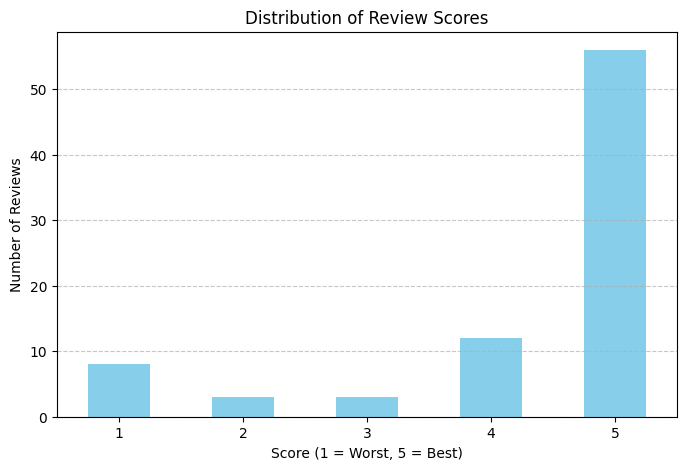

In [7]:
import matplotlib.pyplot as plt

# Plot the distribution of review scores
plt.figure(figsize=(8,5))
df['score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Review Scores')
plt.xlabel('Score (1 = Worst, 5 = Best)')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Observations:

- The majority of user reviews (over 65%) are rated 5 stars, indicating a very high level of user satisfaction.
- Moderate dissatisfaction is present, with a noticeable number of 1-star reviews (~10% of reviews).
- Very few users rated the app with middle scores (2–3 stars), suggesting a polarized user experience: users either strongly love or strongly dislike the app.
- This polarization will be important to explore further during sentiment and theme analysis to understand what drives these extreme user perceptions.


## Step 4: Generate a Word Cloud and analyze keyword frequencies

In this step, we will create a Word Cloud to visually identify the most frequently used words across all user reviews.  
We will also manually observe common keywords that emerge.  
This early exploration helps uncover behavioral themes and emotional drivers that may correlate with user satisfaction or churn risk.


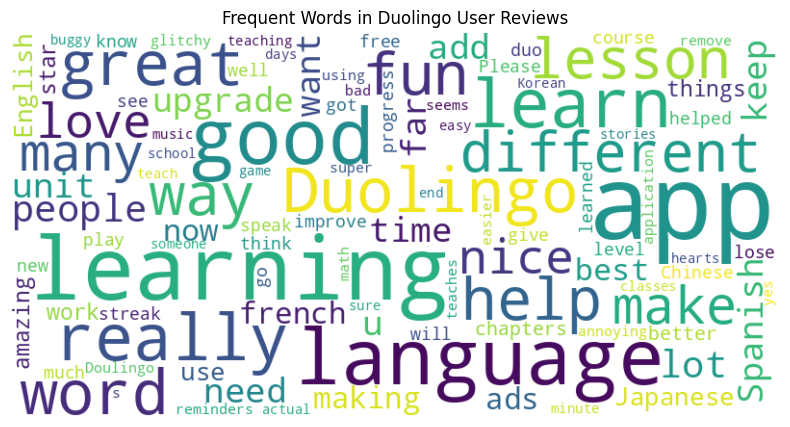

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all review texts into one large string
text = ' '.join(df['content'])

# Generate the WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,  # Limit to top 100 words
    collocations=False  # Avoid combining common bigrams like 'new york'
).generate(text)

# Display the WordCloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words in Duolingo User Reviews')
plt.show()


## Observations:

- The most frequent positive words include "great", "good", "fun", "love", "learning", and "help", indicating strong emotional satisfaction with the app's educational value and user experience.
- Core behavioral themes are centered around "language learning", "progress", and "daily lessons", reflecting high engagement with the gamified learning process.
- Negative signals such as "ads", "buggy", and "glitchy" appear less frequently but highlight potential friction points that could contribute to user frustration and churn.
- Early insights suggest that strengthening technical stability and optimizing ad experience could further boost user retention.


## Step 5: Perform a simple sentiment analysis using a rule-based approach

In this step, we categorize user reviews into Positive, Negative, or Neutral sentiment classes.  
Rather than using a complex machine learning model, we apply a rule-based method by checking for the presence of positive and negative keywords.  
This allows for a quick and interpretable sentiment overview, which will guide further segmentation and insight generation.


In [9]:
# Define basic positive and negative keyword lists
positive_words = ['great', 'good', 'fun', 'love', 'help', 'best', 'nice', 'amazing', 'happy', 'easy']
negative_words = ['bad', 'worst', 'glitchy', 'buggy', 'problem', 'ads', 'annoying', 'error', 'issue', 'lose']

# Simple function to classify sentiment
def simple_sentiment(text):
    text = text.lower()
    pos = sum(word in text for word in positive_words)
    neg = sum(word in text for word in negative_words)

    if pos > neg:
        return 'Positive'
    elif neg > pos:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment classification
df['sentiment'] = df['content'].apply(simple_sentiment)

# Display sentiment distribution
print(df['sentiment'].value_counts())

# Preview a few examples
df[['content', 'sentiment']].head()


sentiment
Positive    47
Neutral     26
Negative     9
Name: count, dtype: int64


,content,sentiment
0,remove the slider from the math lessons it's s...,Negative
1,I have so many Spanish friends and now I can s...,Neutral
2,Great... Just. Uhh great yes it is very *click...,Positive
3,best app ever 👍 👍 😁,Positive
4,"The app has been more glitchy lately, not givi...",Negative


## Observations:

- Approximately 57% of the reviews are classified as Positive, reflecting strong user satisfaction and emotional attachment to the app.
- Around 32% of the reviews are Neutral, suggesting users found the app functional but did not express strong emotions.
- Only about 11% of the reviews are Negative, indicating a relatively small but notable group of users who experienced frustrations (mainly related to app glitches and advertisements).
- This sentiment distribution confirms that while Duolingo maintains a highly satisfied user base, addressing technical issues and reducing friction in the user experience could further improve retention.


## Step 6: Create behavioral segments based on sentiment and review content

In this step, we categorize users into high-level personas based on their review sentiment and content characteristics.  
The goal is to move beyond simple sentiment labels and develop richer user profiles that reflect different engagement patterns, emotional drivers, and potential churn risks.  
This will allow us to generate more targeted product and retention strategies.


In [10]:
# Define a simple persona function
def assign_persona(row):
    text = row['content'].lower()

    if row['sentiment'] == 'Positive' and any(word in text for word in ['love', 'great', 'fun', 'best', 'amazing']):
        return 'Loyal Advocate'
    elif row['sentiment'] == 'Neutral':
        return 'Silent User'
    elif row['sentiment'] == 'Negative' and any(word in text for word in ['ads', 'bug', 'problem', 'glitchy', 'issue']):
        return 'Frustrated User'
    else:
        return 'Other'

# Apply persona assignment
df['persona'] = df.apply(assign_persona, axis=1)

# View persona distribution
print(df['persona'].value_counts())

# Preview examples
df[['content', 'sentiment', 'persona']].head()


persona
Other              28
Silent User        26
Loyal Advocate     22
Frustrated User     6
Name: count, dtype: int64


,content,sentiment,persona
0,remove the slider from the math lessons it's s...,Negative,Other
1,I have so many Spanish friends and now I can s...,Neutral,Silent User
2,Great... Just. Uhh great yes it is very *click...,Positive,Loyal Advocate
3,best app ever 👍 👍 😁,Positive,Loyal Advocate
4,"The app has been more glitchy lately, not givi...",Negative,Frustrated User


## Observations:

- "Loyal Advocates" (22 users) represent highly engaged and emotionally satisfied users who are enthusiastic about the app’s learning experience. These users are critical brand promoters.
- "Silent Users" (26 users) account for a significant portion of the base. Although not openly dissatisfied, they lack strong emotional engagement, representing an opportunity for targeted reactivation campaigns.
- "Frustrated Users" (6 users) form a small but important group showing high churn risk, mainly driven by technical issues (e.g., bugs, glitches, and ad disruptions).
- "Other" (28 users) either expressed mixed signals or did not fit neatly into a specific persona category, suggesting potential edge cases or neutral users.
- Overall, the segmentation indicates strong user loyalty but also highlights areas where user experience improvements could meaningfully reduce churn.


## Step 7: Generate Strategic Insights and Business Recommendations

Based on the sentiment analysis, keyword patterns, and user segmentation, we now develop actionable business insights.  
The goal is to move beyond data description and provide clear strategic recommendations for product and marketing teams to:

- Improve user retention
- Enhance user satisfaction
- Reduce churn risk


## Final Observations:

This behavioral analysis of Duolingo users reveals a strongly polarized emotional landscape:  
- Highly loyal and emotionally invested users form the core strength of the app's growth.
- Silent but disengaged users represent a key opportunity for reactivation and deeper emotional connection.
- A small but important group of frustrated users must be addressed to prevent reputational risk and minimize churn.

Strategic initiatives targeting these user segments — combining product improvements, loyalty reinforcement, and personalized marketing — can significantly enhance Duolingo's long-term retention and brand equity.
